In [1]:
#Basic Imports
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

In [2]:
#Reflect Tables into SQLAlchemy ORM

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True) 

Base.classes.keys()

['measurement', 'station']

In [3]:
trip_start_date = '2017-07-11'
trip_end_date = '2017-07-24'

In [4]:
#Save References to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
#Exploratory Climate Analysis 

# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_12_mos = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= "2016-01-09").\
filter(Measurement.date <= "2017-01-08").all()
precip_12_mos

precip_df = pd.DataFrame(precip_12_mos)
precip_df

#DateTime
precip_df['date'] = pd.to_datetime(precip_df['date'])

#Sort DataFrame by Date & column rename

precip_df = precip_df.set_index('date')                                     
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)       

precip_df.head()


# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

,precipitation
date,
2016-01-09,0.03
2016-01-10,0.01
2016-01-11,0.00
2016-01-12,0.00
2016-01-13,0.00


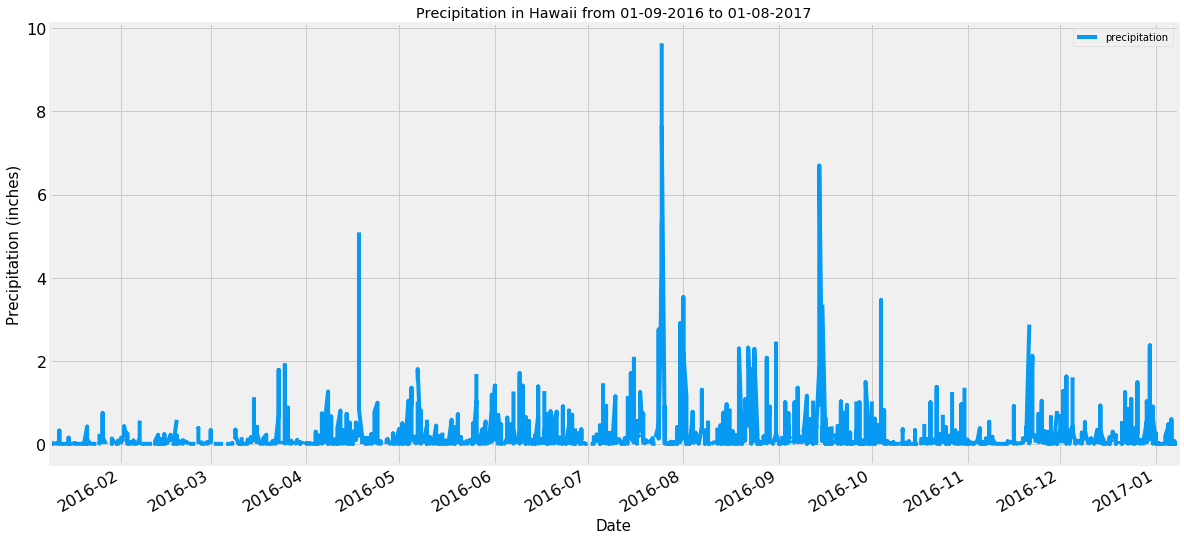

In [7]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(figsize=(18, 9),                                              
               sort_columns=True, 
               rot=30, 
               use_index=True, 
               title='Precipitation in Hawaii from 01-09-2016 to 01-08-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('Date', fontsize=15)
plt.ylabel('Precipitation (inches)', fontsize=15)
plt.show()

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe() 

,precipitation
count,2068.000000
mean,0.178690
std,0.505209
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [9]:
#Station Analysis 

# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()                            
station_count

print(f'There are {station_count} weather stations in Hawaii.')

There are 9 weather stations in Hawaii.


In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
station_activity


[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all()



[(54.0, 85.0, 71.66378066378067)]

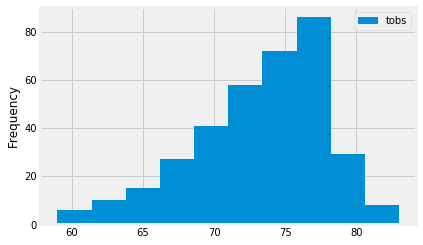

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_list = []
highesttemp = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(highesttemp, columns=['tobs'])

temp_df.plot.hist()


In [13]:
def calc_temps(start, end):
    
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [14]:
def get_prev_year_date(target):
    try:
        x1 = target.split('-')
        xc = (str(int(x1[0])-1)) + '-' + x1[1] + '-' + x1[2]
        return xc
    except:
        return target

In [15]:
start_conv = get_prev_year_date(trip_start_date)
end_conv = get_prev_year_date(trip_end_date)

In [16]:
temp_list = calc_temps(start_conv, end_conv)

In [17]:
temp_list

[77.3529411764706, 71.0, 82.0]

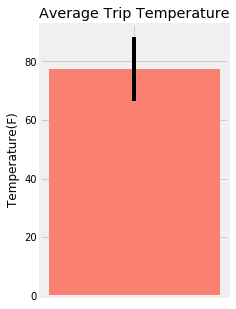

In [18]:
plt.figure(figsize=(3,5))

plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='salmon')
plt.ylabel("Temperature(F)")
plt.title("Average Trip Temperature")
plt.show()


In [19]:
station_rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp).label('Precipitation')).\
filter(Measurement.station == Station.station, Measurement.date >= start_conv, Measurement.date <= end_conv).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


In [20]:
prcp_df = pd.DataFrame(station_rainfall)

In [21]:
prcp_df = prcp_df.set_index('station')
del prcp_df['name']

In [22]:
prcp_df

,Precipitation
station,
USC00516128,9.20
USC00519281,3.86
USC00513117,2.10
USC00514830,1.97
USC00519397,1.96
USC00519523,1.44
USC00517948,0.50


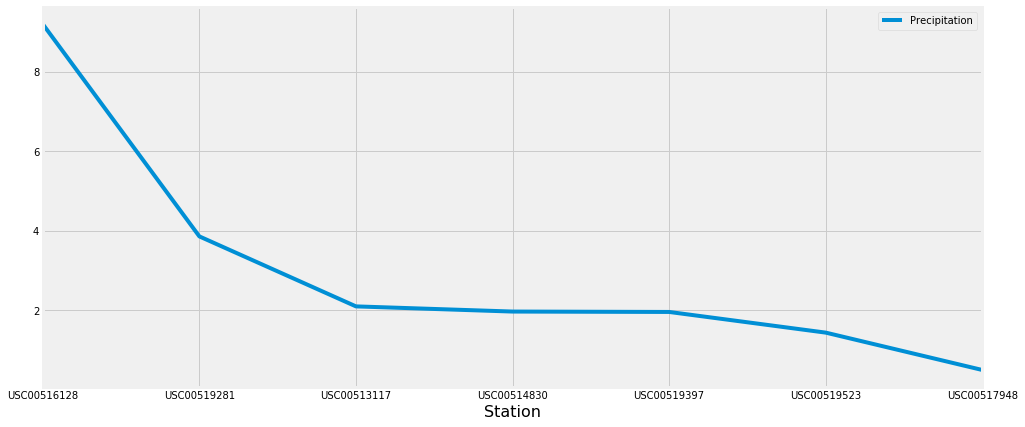

In [23]:
prcp_df.plot(figsize = (15,7)), 

sort_columns=True, 
use_index=True
title='Precipitation by Station during Trip Dates'
legend=True
fontsize=14
grid=True
color='xkcd:azure'
plt.xlabel('Station', fontsize=16)
plt.show()

In [24]:
def get_pdate(target):
    target_parse = target.split('-')
    return target_parse[1] + '-' + target_parse[2]

In [25]:
def daily_normals(target_date):
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date.like('%' + get_pdate(target_date))).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(target_date)
    temp_list.append(min(temperatures))
    temp_list.append(np.mean(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [26]:
def get_date_list(start_date, end_date):
    date_list = []
    
    tsds = start_date.split('-')
    teds = end_date.split('-')
    
    begin = dt.date(int(tsds[0]), int(tsds[1]), int(tsds[2]))
    end = dt.date(int(teds[0]), int(teds[1]), int(teds[2]))
    
    next_day = begin
    while True:
        if next_day > end:
            break
        date_list.append(str(next_day))
        next_day += dt.timedelta(days=1)
    return date_list

In [27]:
target_date_list = get_date_list(start_conv, end_conv)

In [28]:
data_list = []
for item in target_date_list:
    data_list.append(daily_normals(item))

In [29]:
daily_norm_df = pd.DataFrame(data_list, columns=['date', 'tmin', 'tavg', 'tmax'])
daily_norm_df = daily_norm_df.set_index('date')
daily_norm_df

,tmin,tavg,tmax
date,,,
2016-07-11,70.0,75.789474,81.0
2016-07-12,67.0,75.964912,82.0
2016-07-13,69.0,76.189655,81.0
2016-07-14,61.0,76.228070,82.0
2016-07-15,68.0,76.254237,82.0
2016-07-16,70.0,76.344828,83.0
2016-07-17,70.0,76.301887,83.0
2016-07-18,72.0,76.637931,83.0
2016-07-19,68.0,75.890909,83.0


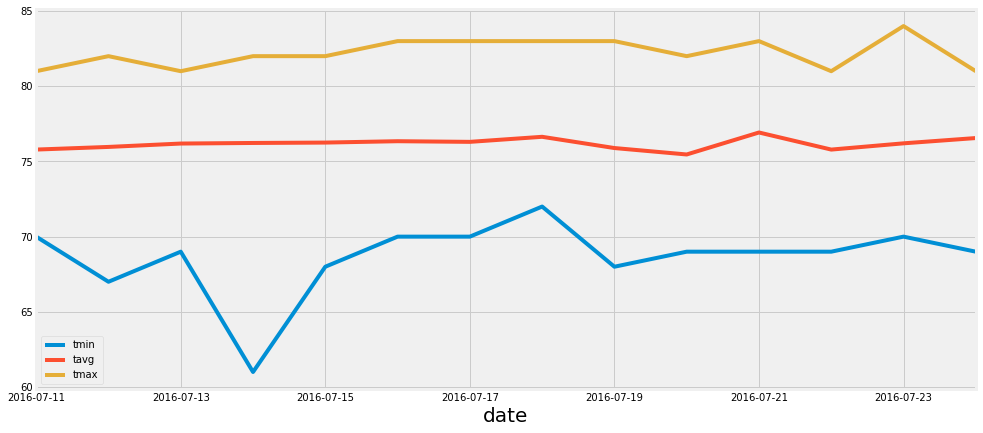

In [30]:
daily_norm_df.plot(figsize=(15,7))
kind='area'
sort_columns=True
rot=45
use_index=True
title='Daily Normals in Hawaii during Trip Dates'
stacked=False
legend='reverse'
fontsize=20
grid=True
plt.xlabel('date', fontsize=20)
plt.show()